# Project Part 2 Solutions

## (a)

In [1]:
import numpy as np

file=np.load("part2.npz")
beta_old=file['beta_old']
N=file['N']
Svc_0_PMF=file['Svc_0_PMF']
Lc=file['Lc']
Ic_0=file['Ic_0']
gamma=file['gamma']
L_observed=file['L_observed']
nb_nodes = Svc_0_PMF.shape[0]
file.files
Svc_0_PMF.shape[1]


4

In [2]:
def SIR(t, Z, N, betas, gamma):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -betas*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [3]:
def SIR1(t, Z, N, betas, gamma,alpha):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -(betas*alpha)*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [4]:
from random import seed
from random import random
def loss_func(alpha,node_index,N):
    initial_conditions = np.concatenate((S[node_index,:,:,9].flatten(), I[node_index,:,9], [R[node_index,9]]))
    soln = solve_ivp(SIR1, (t[10], t[29]), initial_conditions, args=(N, beta_old, gamma,alpha), t_eval=t[10:30])

    S[node_index, :, :, 10:30] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, 10:30] = soln.y[16:20]
    R[node_index, 10:30] = soln.y[20]
    L[node_index, 10:30] = Lc@soln.y[16:20]
    Lpredicted=L[node_index, 10:30]
    mse= mean_squared_error(Lpredicted,L_observed[node_index,10:30])
    #breakpoint()
    return mse


In [5]:
from scipy.integrate import solve_ivp
from scipy.optimize import fmin
from sklearn.metrics import mean_squared_error

Svc_0_PMF /= Svc_0_PMF.sum(axis=(1, 2), keepdims=True)
Svc_0 = (N-Ic_0.sum(axis=1))[:, np.newaxis, np.newaxis]*Svc_0_PMF
Svc_0 = Svc_0.round().astype(int)
R0 = np.zeros((nb_nodes)).astype(int)

t = np.linspace(0, 199, 200)

S = np.zeros((nb_nodes, 4, 4, len(t)))
I = np.zeros((nb_nodes, 4, len(t)))
R = np.zeros((nb_nodes, len(t)))
L = np.zeros((nb_nodes, len(t)))

for N_node, node_index in zip(N, range(nb_nodes)):

    initial_conditions = np.concatenate((Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))

    soln = solve_ivp(SIR, (t[0], t[9]), initial_conditions, args=(N_node, beta_old, gamma), t_eval=t[:10])

    S[node_index, :, :, :10] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, :10] = soln.y[16:20]
    R[node_index, :10] = soln.y[20]
    L[node_index, :10] = Lc@soln.y[16:20]


alpha_predicted = np.zeros((nb_nodes))
S[node_index,:,:,0:200].sum()

187352.5410318418

In [6]:
for N_node, node_index in zip(N, range(nb_nodes)):
    alpha_predicted[node_index] = fmin(loss_func, 0.5,args=(node_index,N_node,),disp=False)
    #breakpoint()


In [9]:
dsort=np.argsort(alpha_predicted)
alpha_predicted[0]
a=np.array([alpha_predicted.flatten()])
#print(np.argsort(a),alpha_predicted[14])
#for n in d:
    #print(n)
print(dsort)
print(sorted_alphas)

[14 50 19 70 96 54 37 25 69 33 90  9 43 56 16 95 66  5 79 51 13 49 27  2
 15 93  0 48 98 64 44 86 92 23 53 20 21 61 58 10 38 84 85 72 30 31 75 12
 11 36 80 91 47 52 71 24 62  7 83  6  8 60 78 26 67 32  1 40 74 45 63 41
 42 28 73 94 68 22 81 89 65 57 87 17 59 76 18 34 35 77 55 29 99  4 46 82
  3 97 39 88]
[[0.12352142 0.13822021 0.14249268 0.14443359 0.14606934 0.14807129
  0.15137939 0.15171814 0.1552803  0.16387329 0.16503143 0.16713867
  0.17045288 0.17644043 0.18051758 0.19622192 0.20018311 0.20029602
  0.20103149 0.20452881 0.20931396 0.20965576 0.21018066 0.22185059
  0.22246094 0.22650146 0.22669983 0.23173828 0.23728027 0.24645996
  0.24889221 0.25011292 0.25706787 0.26390381 0.26639404 0.26811523
  0.27178955 0.27543945 0.27561264 0.27568665 0.28189697 0.28358765
  0.28780823 0.2932373  0.29797363 0.3010498  0.30296936 0.31580811
  0.32045898 0.3225708  0.32358704 0.33059082 0.330896   0.33418884
  0.33525391 0.33642883 0.34067383 0.35007172 0.35155029 0.35754395
  0.3601532  0

In [69]:
q=alpha_predicted[0]
a=loss_func(q,0,N[0])
print("MSE",a)
print("Alpha",q)

MSE 1.8315665422032086
Alpha 0.22669982910156228


In [8]:
sorted_alphas=np.array([alpha_predicted])
sorted_alphas.sort()
print("Nodes ranked by how high theyre alphas is",sorted_alphas)

Nodes ranked by how high theyre alphas is [[0.12352142 0.13822021 0.14249268 0.14443359 0.14606934 0.14807129
  0.15137939 0.15171814 0.1552803  0.16387329 0.16503143 0.16713867
  0.17045288 0.17644043 0.18051758 0.19622192 0.20018311 0.20029602
  0.20103149 0.20452881 0.20931396 0.20965576 0.21018066 0.22185059
  0.22246094 0.22650146 0.22669983 0.23173828 0.23728027 0.24645996
  0.24889221 0.25011292 0.25706787 0.26390381 0.26639404 0.26811523
  0.27178955 0.27543945 0.27561264 0.27568665 0.28189697 0.28358765
  0.28780823 0.2932373  0.29797363 0.3010498  0.30296936 0.31580811
  0.32045898 0.3225708  0.32358704 0.33059082 0.330896   0.33418884
  0.33525391 0.33642883 0.34067383 0.35007172 0.35155029 0.35754395
  0.3601532  0.36387939 0.37408447 0.3757782  0.38779907 0.39297028
  0.39484253 0.41170807 0.41690369 0.41756592 0.42473755 0.43126221
  0.43154907 0.44144897 0.44838867 0.45488892 0.46865234 0.49281006
  0.51626587 0.51790771 0.52313232 0.53582764 0.54241028 0.56386719
  0.56

## (b)

In [52]:
sorted_alphas=sorted_alphas.flatten()
#sorted_alphas[0]

In [53]:
def before_alph(alpha):
    totalbfNPI=[]
    for old_index , node_index in zip(dsort,range(nb_nodes)):#dsort is the alphas ranked
        #breakpoint
        initial_conditions = np.concatenate((S[old_index,:,:,29].flatten(), I[old_index,:,29], [R[old_index,29]]))
        soln = solve_ivp(SIR1, (t[30], t[-1]), initial_conditions, args=(N[old_index], beta_old, gamma,alpha[node_index]), t_eval=t[30:200])
        #breakpoint
        R[node_index, 30:200] = soln.y[20]
        total=R[node_index,-1].sum()
        totalbfNPI.append(total)
       
    #breakpoint()
    
    return totalbfNPI

totalbfNPI1=before_alph(sorted_alphas)


In [54]:
def g(money):
    alpha = 1/np.log2(2*10**(-3)*money+2)
    return alpha

def g_inv(alpha):
    money = (2**(1/alpha)-2)/(2*10**(-3))
    return money
    import matplotlib.pyplot as plt 

def scatter_plot(alpha_afterNPI):
    plt.figure()
    colors=(beta_old[np.newaxis,:,:]*Svc_0_PMF).mean(axis=(1,2))
    plt.scatter(sorted_alphas,alpha_afterNPI, s=N/500, c=colors, cmap='jet', alpha=0.5)
    plt.xlabel(r"$\alpha_{own}$")
    plt.ylabel(r"$\alpha_{after\ NPI}$")
    #plt.axis([0, 1, 0, 1])


S1 = np.zeros((nb_nodes, 4, 4, len(t)))
R1 = np.zeros((nb_nodes, len(t)))
print(S1.shape)
def total_recovered_difference(alpha_afterNPI):
    #dif=0
    totalafNPI=[]
    dif=0
    for old_index , node_index in zip(dsort,range(nb_nodes)):#dsort is the alphas ranked 
        initial_conditions = np.concatenate((S[old_index,:,:,29].flatten(), I[old_index,:,29], [R[old_index,29]]))
        soln1= solve_ivp(SIR1, (t[30], t[199]), initial_conditions, args=(N[old_index], beta_old, gamma,alpha_afterNPI[node_index]), t_eval=t[30:200])
       

        
        R1[node_index, 30:200] = soln1.y[20]
        total1=R1[node_index,-1].sum()
        totalafNPI.append(total1)
    for row in range(nb_nodes):
        dif+= -totalafNPI[row]+totalbfNPI1[row]
        #difference.append(dif)
        #a=difference.sum()
            
    
    
    
    return dif 


(100, 4, 4, 200)


### Policy #1

In [55]:
#i.
A1=[]
Newmoney=[]
for r in dsort: #dsort is the alphas ranked
    n=g_inv(alpha_predicted[r])
    nm=n+10000
    An=g(nm)
    m=g_inv(An)
    A1.append(An)
    Newmoney.append(m)

    

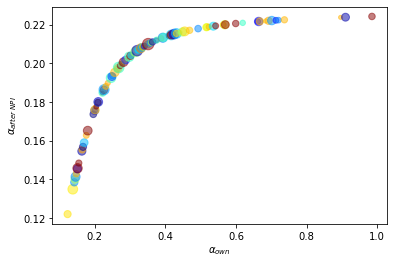

In [56]:
scatter_plot(A1)

In [57]:
#ii
total_recovered_difference(A1)

329723.9274361072

### Policy #2

In [27]:
nsum=N.sum()

In [39]:
#i
N_percent=N/nsum
money=[]
for r in dsort:
    money.append(N_percent[r]*1000000)

A2=[]
Newmoney=[]
for r in dsort: #dsort is the ranked nodes 
    n=g_inv(alpha_predicted[r])
    nm=n+money[r]
    An=g(nm)
    m=g_inv(An)
    A2.append(An)
    Newmoney.append(m)

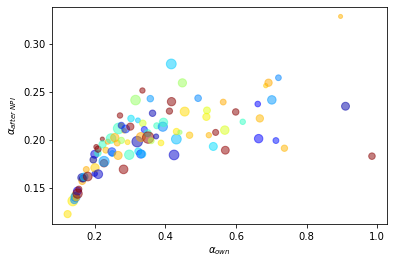

In [40]:
import matplotlib.pyplot as plt
scatter_plot(A2)

In [58]:
#ii
total_recovered_difference(A2)

321196.4032715471

### Policy #3

i.

ii.

### Policy #4

i.

ii.

## (c)

### Policy 1

### Policy 2

### Policy 3

### Policy 4